In [1]:
# Import libraries
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet
from pmdarima import auto_arima
from pylab import rcParams
import warnings 
warnings.filterwarnings("ignore")
import calendar
import pickle

In [2]:
# Read data
df = pd.read_csv('train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
# Fill missing values
df = df.fillna(0)

In [4]:
# Reshaping the dataframe
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [5]:
# Setting 'Date' column as the index 
df_reshaped['Date'] = pd.DatetimeIndex(df_reshaped['Date'])
df_reshaped = df_reshaped.set_index('Date')

## Time series analysis

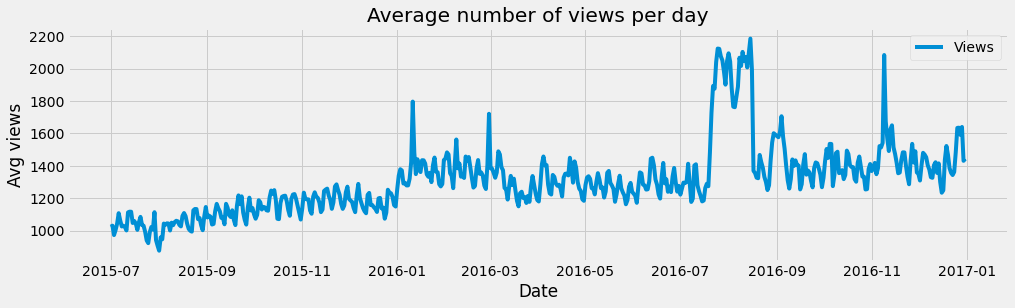

In [6]:
# Average number of views per day
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.title('Average number of views per day')
plt.plot(temp,label='Views')
plt.legend()
plt.show()

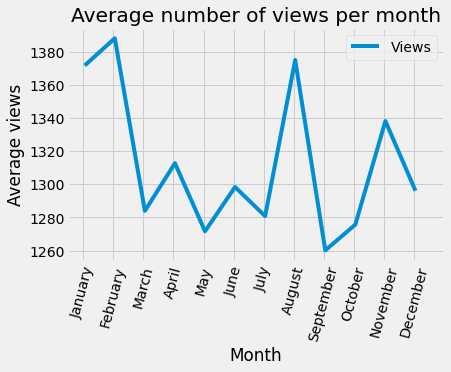

In [7]:
# Average number of views per month
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','February','March','April','May','June','July','August','September','October','November','December']
ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
ax.set_title('Average number of views per month')
plt.show()

In [8]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
temp1 = df_reshaped  
temp1['Wikipedia_page'] = temp1.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
temp1['Page_language'] = temp1.Wikipedia_page.apply(lang_code)

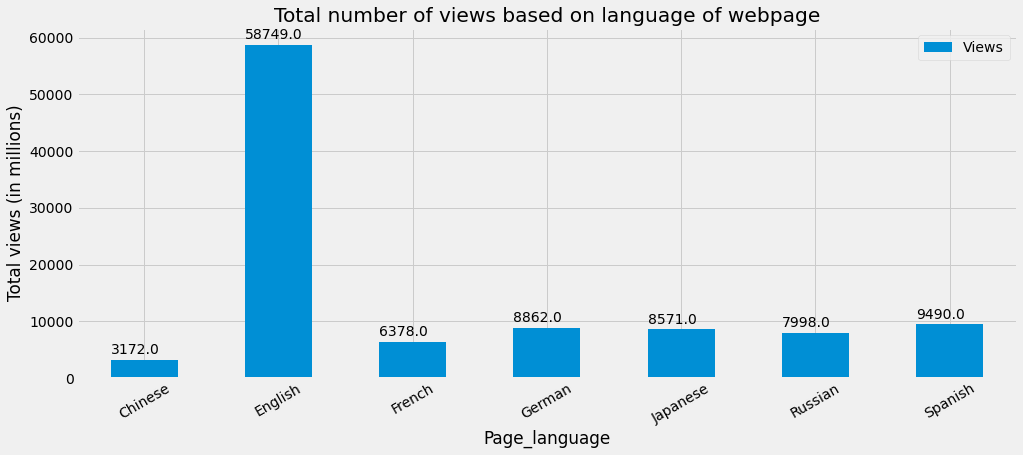

In [9]:
# Total number of views based on language of Wikipedia webpage
fig,ax = plt.subplots(figsize=(15,6))
lang_df = temp1.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')
bar_graph.set_title('Total number of views based on language of webpage')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1000))
ax.legend()
plt.show()

In [10]:
# Extracting day of week from date
days_df = df_reshaped.copy()
days_df = days_df[['Page','Views']]
days_df['Dayofweek'] = days_df.index.dayofweek

In [11]:
def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
days_df['Day'] = days_df.Dayofweek.apply(find_day)

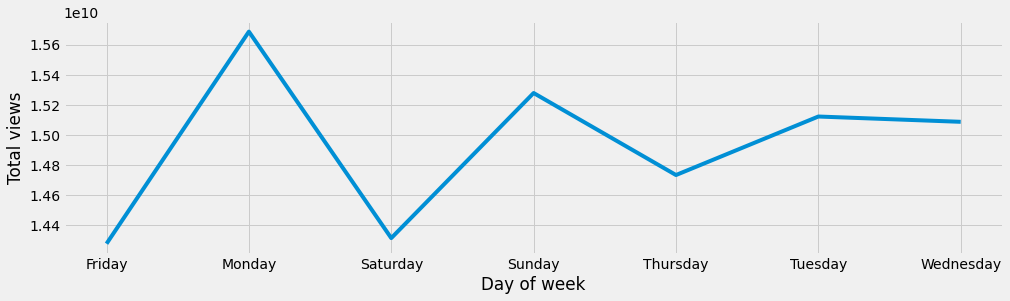

In [12]:
day = days_df.groupby('Day')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [13]:
# Top 5 pages with maximum number of views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

In [14]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(top_pages_list)]

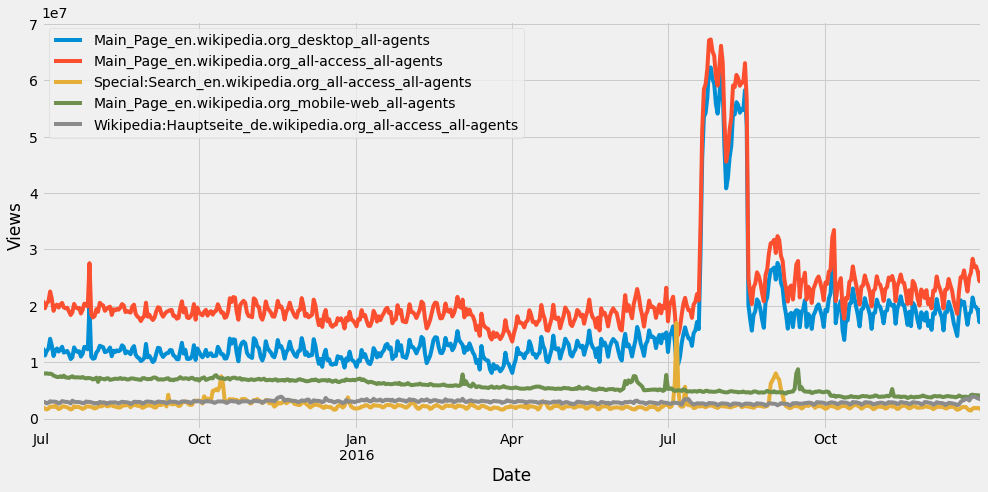

In [15]:
# Plot with top 5 pages which have maximum number of views
fig, ax = plt.subplots(figsize=(15,7))
for i in list(top5_pages_df.Page.unique())[:5]:
    top5_pages_df.loc[top5_pages_df.Page == i].plot(ax=ax)

ax.set_ylabel('Views')
ax.legend(list(top5_pages_df.Page.unique())[:5],loc='upper left')
plt.show()

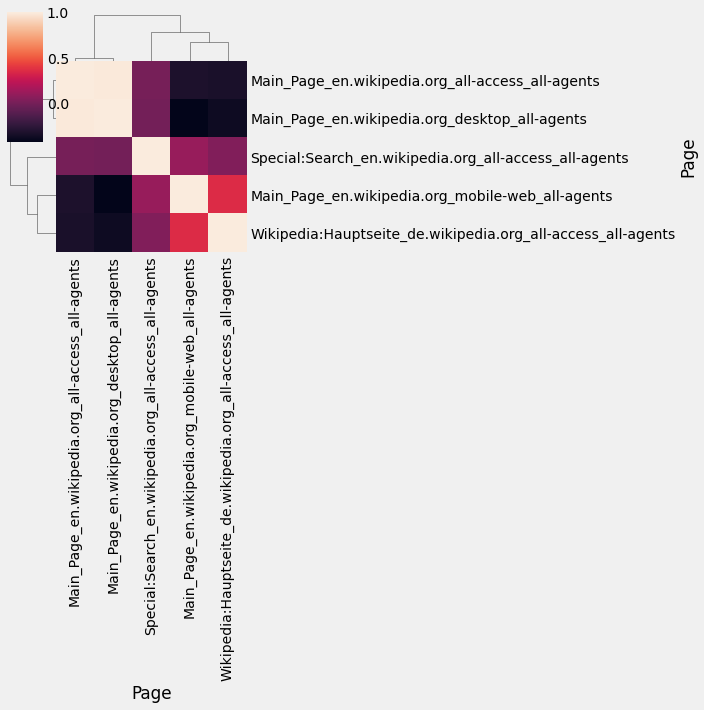

In [16]:
# Correlation between pages
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [17]:
# Time-series of page with maximum views
top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


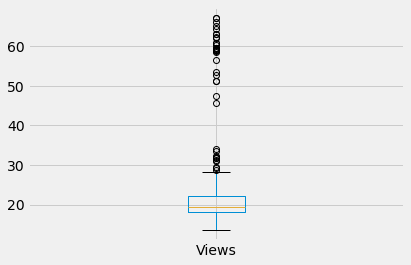

In [18]:
ax1 = top_page_df.boxplot()

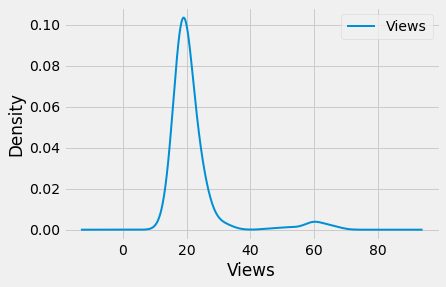

In [19]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

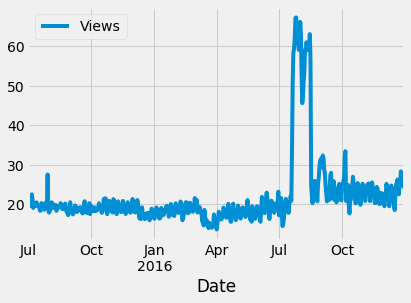

In [20]:
top_page_df.plot()

- The above data will be used in the time-series forecasting models.
- As seen in the figure above, there are anomalies in the data. Using data with anomalies for forecasting will affect the accuracy of the model. Hence, the anomalies are removed using Isolation Forest.

## Anomaly detection using Isolation Forest

In [21]:
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

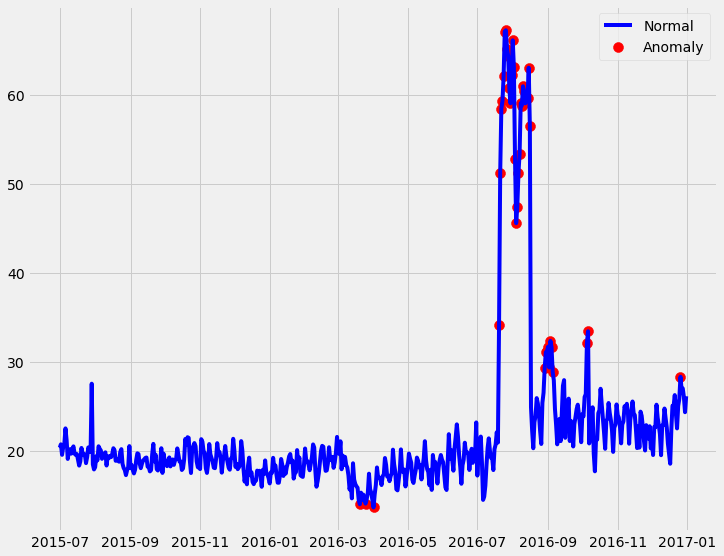

In [22]:
fig, ax = plt.subplots(figsize=(11,9))
anomaly_df = top_page_df.loc[top_page_df['anomaly'] == -1].copy()
ax.plot(top_page_df.index,top_page_df['Views'],color='blue', label = 'Normal')
plt.scatter(anomaly_df.index,anomaly_df['Views'],color='red',s=100,label = 'Anomaly')
plt.legend()
plt.show()

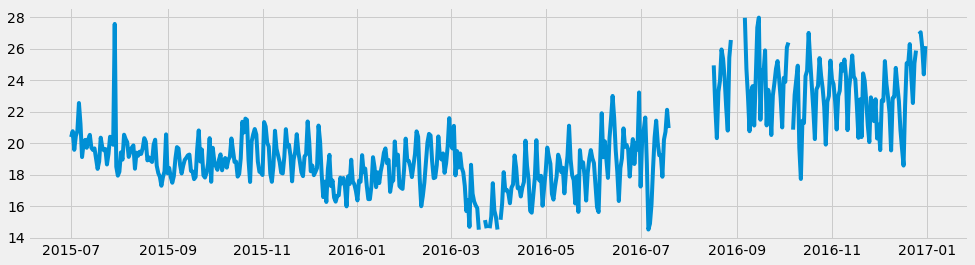

In [23]:
# Removing anomalies from the data
top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
plt.figure(figsize=(15,4))
plt.plot(top_page_df.index,top_page_df.new_views)

- Removing anomalies in the data creates some missing values.
- The missing values are filled with rolling mean or moving average of 30 days.

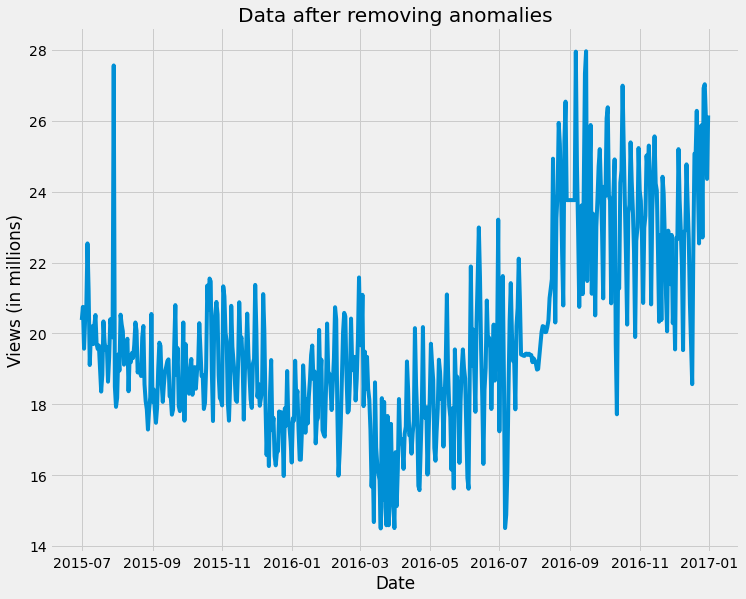

In [24]:
# Filling missing data with rolling mean
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))

plt.figure(figsize=(11,9))
plt.plot(top_page_df.index,top_page_df.rolling_mean)
plt.title('Data after removing anomalies')
plt.xlabel('Date')
plt.ylabel('Views (in millions)')
plt.show()

In [25]:
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

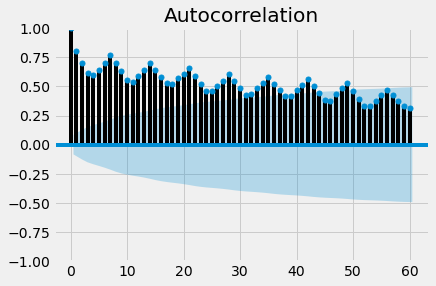

In [26]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

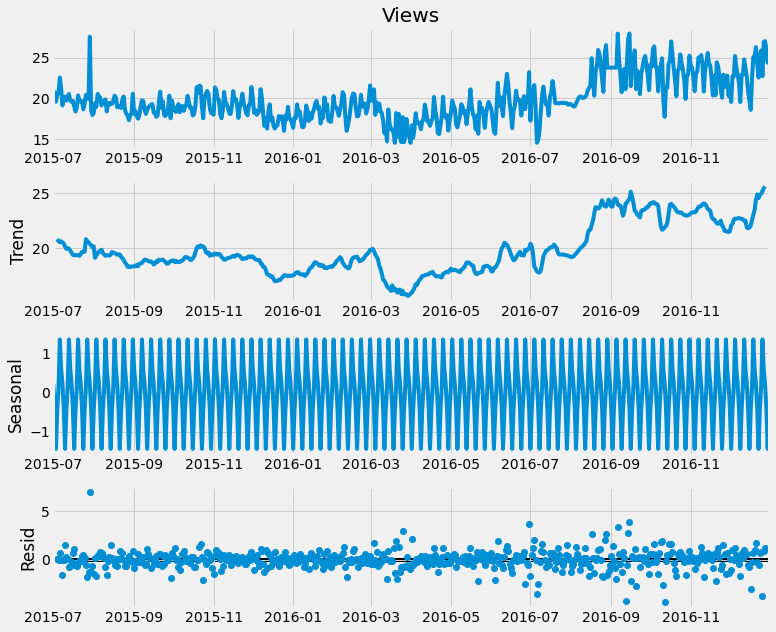

In [27]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df.Views)
figure = ts_decomposition.plot()

### Augmented Dicky-Fuller test

In [28]:
test = adfuller(top_page_df['Views'])
print(test)

(-0.49486561591415273, 0.8930145488076986, 14, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1788.1870153251816)


 - First element is the test statistic. Test statistic shows how likely the data is stationary.
 - Second element indicates the p-value. Since the p-value is not < 0.05, we cannot reject null hypothesis. The null hypothesis is that data is not stationary. Therefore, data is not stationary.

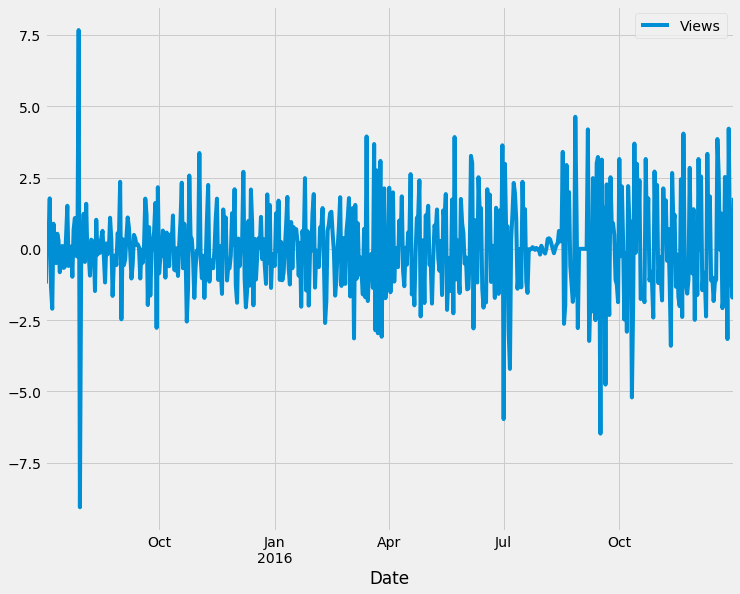

In [29]:
# Differencing the data to make it stationary
top_page_stationary_df = top_page_df.diff().dropna()
ax = top_page_stationary_df.plot()

In [30]:
# Augmented dicky-fuller test on stationary data
test2 = adfuller(top_page_stationary_df['Views'])
print(test2)

(-8.189701414241295, 7.727194226786915e-13, 13, 535, {'1%': -3.4426321555520905, '5%': -2.86695748394138, '10%': -2.5696553279762426}, 1784.0982153113002)


- We can see that the test statistic is more for stationary data. This means that the data is now more likely to be stationary.
- Since the p-value(second element) is less than 0.05, null hypothesis can be rejected. Therefore, data is stationary.

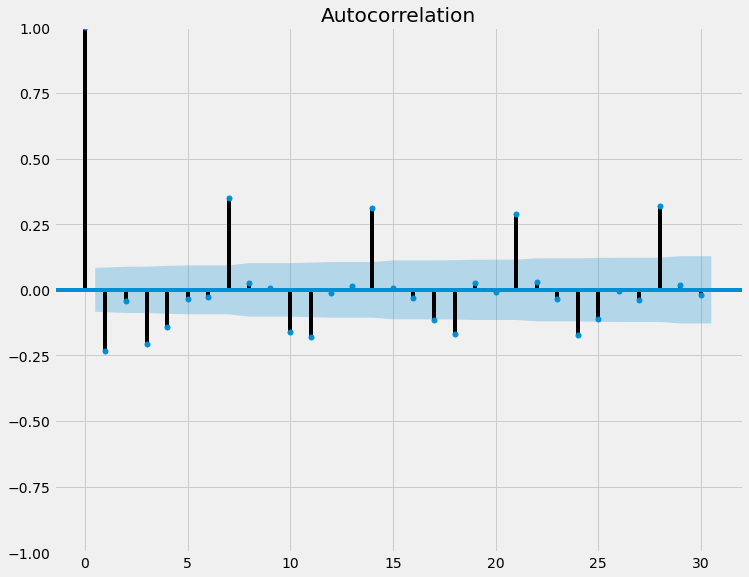

In [31]:
fig = tsaplots.plot_acf(top_page_stationary_df['Views'], lags=30)
plt.show()

## Preparing the data for modeling

In [32]:
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

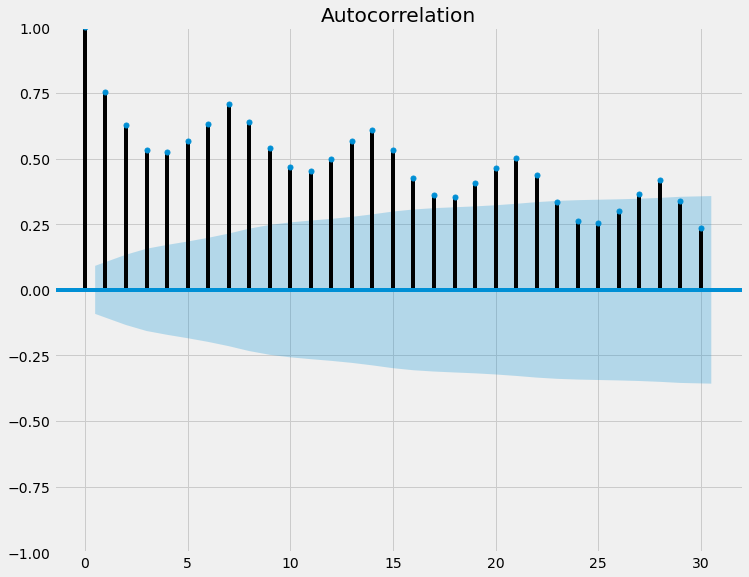

In [33]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

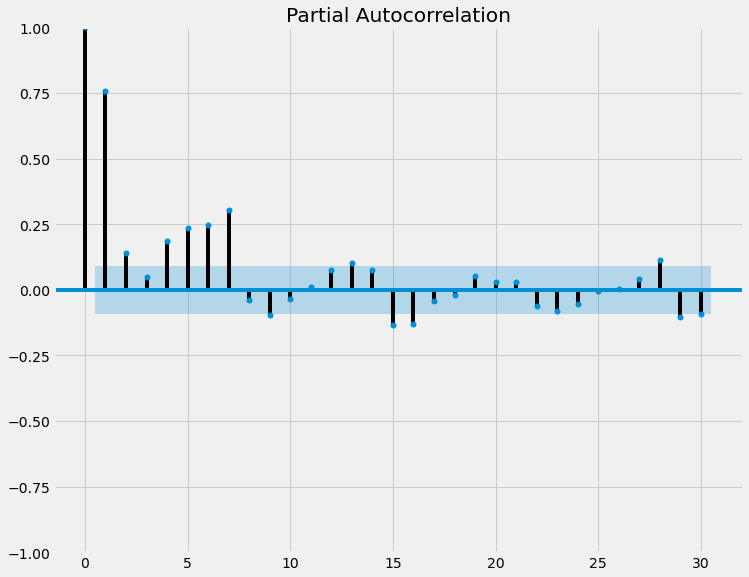

In [34]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

## ARMA model

In [35]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38031D+00    |proj g|=  2.68230D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.682D-08   4.380D+00
  F =   4.3803090898829584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.91537D+00    |proj g|=  4.32888D-01

At iterate   10    f=  2.79002D+00    |proj g|=  2.21903D-02

At iterate   15    f=  2.78738D+00    |proj g|=  2.50953D-02

At iterate   20    f=  2.77999D+00    |proj g|=  3.58546D-02

At iterate   25    f=  2.77729D+00    |proj g|=  1.86898D-03

At iterate   30    f=  2.77729D+00    |proj g|=  3.98259D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     49      1     0     0   3.983D-06   2.777D+00
  F =   2.7772878667875340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.16920D+00    |proj g|=  1.43773D+00

At iterate   10    f=  2.45582D+00    |proj g|=  4.59452D-02

At iterate   15    f=  2.45292D+00    |proj g|=  1.96686D-02

At iterate   20    f=  2.45237D+00    |proj g|=  3.01557D-03

At iterate   25    f=  2.45236D+00    |proj g|=  1.00314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     42      1     0     0   1.003D-05   2.452D+00
  F =   2.4523621463676832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.72732D+00    |proj g|=  5.30585D-04

At iterate   10    f=  1.72732D+00    |proj g|=  1.69547D-03

At iterate   15    f=  1.72710D+00    |proj g|=  1.90504D-02

At iterate   20    f=  1.72577D+00    |proj g|=  1.38249D-03

At iterate   25    f=  1.72571D+00    |proj g|=  4.00555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     30      1     0     0   6.382D-06   1.726D+00
  F =   1.7257111377073127     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  1.70941D+00    |proj g|=  1.24094D-03

At iterate   20    f=  1.70920D+00    |proj g|=  9.09568D-03

At iterate   25    f=  1.70877D+00    |proj g|=  5.88317D-04

At iterate   30    f=  1.70877D+00    |proj g|=  1.21096D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     34      1     0     0   5.084D-06   1.709D+00
  F =   1.7087700395422514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   25    f=  1.76568D+00    |proj g|=  8.79986D-02

At iterate   30    f=  1.71104D+00    |proj g|=  5.32163D-02

At iterate   35    f=  1.69625D+00    |proj g|=  8.37099D-03

At iterate   40    f=  1.69436D+00    |proj g|=  3.36022D-03

At iterate   45    f=  1.69432D+00    |proj g|=  2.38348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     54      1     0     0   1.476D-05   1.694D+00
  F =   1.6943223335745223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11299D+05    |proj g|=  2.21869D+05

At iterate    5    f=  1.92034D+02    |proj g|=  4.38261D+02

At iterate   10    f=  1.13511D+01    |proj g|=  1.41608D+01

At iterate   15    f=  2.87132D+00    |proj g|=  5.18839D-01

At iterate   20    f=  1.78449D+00    |proj g|=  7.55163D-02

At iterate   25    f=  1.77695D+00    |proj g|=  5.93960D-03

At iterate   30    f=  1.77413D+00    |proj g|=  1.27611D-02

At iterate   35    f=  1.77307D+00    |proj g|=  1.52675D-04

At iterate   40    f=  1.77299D+00    |proj g|=  1.74278D-03

At iterate   45    f=  1.76847D+00    |proj g|=  4.24915D-02

At iterate   50    f=  1.73699D+00    |proj g|=  1.05868D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.13713D+00    |proj g|=  3.34258D-01

At iterate   10    f=  1.78531D+00    |proj g|=  9.34220D-02

At iterate   15    f=  1.73278D+00    |proj g|=  1.23816D-02

At iterate   20    f=  1.72569D+00    |proj g|=  6.85831D-03

At iterate   25    f=  1.72555D+00    |proj g|=  4.29392D-04

At iterate   30    f=  1.72550D+00    |proj g|=  6.92075D-04

At iterate   35    f=  1.72549D+00    |proj g|=  1.43960D-03

At iterate   40    f=  1.72511D+00    |proj g|=  4.04410D-03

At iterate   45    f=  1.72505D+00    |proj g|=  7.78741D-04

At iterate   50    f=  1.72502D+00    |proj g|=  2.59310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.70218D+00    |proj g|=  7.55860D-04

At iterate   20    f=  1.70204D+00    |proj g|=  1.18908D-02

At iterate   25    f=  1.69779D+00    |proj g|=  1.75546D-02

At iterate   30    f=  1.69676D+00    |proj g|=  2.89821D-03

At iterate   35    f=  1.69670D+00    |proj g|=  8.10912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     42      1     0     0   2.558D-06   1.697D+00
  F =   1.6966995606009745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.72423D+00    |proj g|=  2.77340D-02

At iterate   25    f=  1.71853D+00    |proj g|=  1.65205D-02

At iterate   30    f=  1.71816D+00    |proj g|=  3.78550D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     43      1     0     0   1.575D-06   1.718D+00
  F =   1.7181634388466893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08214D+02    |proj g|=  2.12822D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70846D+00    |proj g|=  9.17190D-02

At iterate    5    f=  1.70020D+00    |proj g|=  2.74624D-02

At iterate   10    f=  1.67829D+00    |proj g|=  2.77635D-02

At iterate   15    f=  1.64983D+00    |proj g|=  9.81954D-02

At iterate   20    f=  1.62875D+00    |proj g|=  6.70150D-02

At iterate   25    f=  1.62059D+00    |proj g|=  2.16057D-02

At iterate   30    f=  1.61678D+00    |proj g|=  6.37078D-01

At iterate   35    f=  1.61309D+00    |proj g|=  6.83514D-01

At iterate   40    f=  1.60966D+00    |proj g|=  1.31472D-01

At iterate   45    f=  1.60902D+00    |proj g|=  3.21385D-02

At iterate   50    f=  1.60898D+00    |proj g|=  5.11855D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   30    f=  1.71010D+00    |proj g|=  8.03929D-03

At iterate   35    f=  1.70184D+00    |proj g|=  3.50350D-02

At iterate   40    f=  1.69776D+00    |proj g|=  2.09285D-03

At iterate   45    f=  1.69702D+00    |proj g|=  1.45722D-02

At iterate   50    f=  1.69573D+00    |proj g|=  4.66847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   4.668D-03   1.696D+00
  F =   1.6957255163652767     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.74337D+00    |proj g|=  4.75547D+00

At iterate   10    f=  2.39812D+00    |proj g|=  3.15790D+00

At iterate   15    f=  2.23124D+00    |proj g|=  9.78092D-01

At iterate   20    f=  2.21514D+00    |proj g|=  1.36396D+00

At iterate   25    f=  2.15453D+00    |proj g|=  2.55288D-01

At iterate   30    f=  2.12333D+00    |proj g|=  1.98027D+00

At iterate   35    f=  2.10794D+00    |proj g|=  6.61057D-01

At iterate   40    f=  2.07896D+00    |proj g|=  8.39756D-01

At iterate   45    f=  2.04880D+00    |proj g|=  1.22424D+00

At iterate   50    f=  2.01395D+00    |proj g|=  7.96488D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  1.82011D+00    |proj g|=  6.22157D-03

At iterate   20    f=  1.81319D+00    |proj g|=  2.33698D-02

At iterate   25    f=  1.81165D+00    |proj g|=  1.97765D-02

At iterate   30    f=  1.81031D+00    |proj g|=  1.51560D-02

At iterate   35    f=  1.80819D+00    |proj g|=  2.14625D-01

At iterate   40    f=  1.80628D+00    |proj g|=  4.00871D-02

At iterate   45    f=  1.80615D+00    |proj g|=  2.49664D-03

At iterate   50    f=  1.80615D+00    |proj g|=  1.61080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   1.611D-03   1.806D+00
  F =   1.806149393946

 This problem is unconstrained.



At iterate   20    f=  1.81971D+00    |proj g|=  3.10524D-02

At iterate   25    f=  1.78977D+00    |proj g|=  4.66358D-01

At iterate   30    f=  1.72402D+00    |proj g|=  6.82301D-01

At iterate   35    f=  1.72134D+00    |proj g|=  1.80556D-01

At iterate   40    f=  1.72129D+00    |proj g|=  1.56544D-03

At iterate   45    f=  1.72129D+00    |proj g|=  2.69263D-03

At iterate   50    f=  1.72128D+00    |proj g|=  4.08098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   4.081D-03   1.721D+00
  F =   1.7212763694908284     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


At iterate   10    f=  1.85714D+00    |proj g|=  3.29230D-01

At iterate   15    f=  1.70518D+00    |proj g|=  9.47649D-02

At iterate   20    f=  1.64482D+00    |proj g|=  3.52928D-01

At iterate   25    f=  1.63015D+00    |proj g|=  4.29842D-02

At iterate   30    f=  1.62514D+00    |proj g|=  2.97997D-02

At iterate   35    f=  1.62349D+00    |proj g|=  9.60714D-02

At iterate   40    f=  1.62302D+00    |proj g|=  3.91987D-01

At iterate   45    f=  1.62218D+00    |proj g|=  3.56452D-02

At iterate   50    f=  1.62200D+00    |proj g|=  5.99948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     88    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  2.77441D+00    |proj g|=  1.15595D+00

At iterate   10    f=  1.79857D+00    |proj g|=  2.74720D-01

At iterate   15    f=  1.73162D+00    |proj g|=  2.38983D-02

At iterate   20    f=  1.72019D+00    |proj g|=  2.46573D-02

At iterate   25    f=  1.70614D+00    |proj g|=  6.11389D-02

At iterate   30    f=  1.66326D+00    |proj g|=  2.03563D-01

At iterate   35    f=  1.64222D+00    |proj g|=  2.98359D-01

At iterate   40    f=  1.63121D+00    |proj g|=  7.73703D-02

At iterate   45    f=  1.62314D+00    |proj g|=  4.02138D-02

At iterate   50    f=  1.61869D+00    |proj g|=  1.12694D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.80276D+00    |proj g|=  1.19451D-01

At iterate   15    f=  1.71625D+00    |proj g|=  2.86658D-02

At iterate   20    f=  1.70866D+00    |proj g|=  8.20589D-03

At iterate   25    f=  1.70788D+00    |proj g|=  3.67703D-03

At iterate   30    f=  1.70763D+00    |proj g|=  4.35958D-03

At iterate   35    f=  1.70747D+00    |proj g|=  5.20851D-03

At iterate   40    f=  1.70746D+00    |proj g|=  1.43991D-03

At iterate   45    f=  1.70744D+00    |proj g|=  6.26147D-04

At iterate   50    f=  1.70744D+00    |proj g|=  1.13188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.68787D+00    |proj g|=  3.97269D-02

At iterate   20    f=  1.67877D+00    |proj g|=  7.55319D-03

At iterate   25    f=  1.67787D+00    |proj g|=  1.76836D-03

At iterate   30    f=  1.67786D+00    |proj g|=  4.59792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     39      1     0     0   4.797D-06   1.678D+00
  F =   1.6778554596525268     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.69117D+00    |proj g|=  1.13441D-02

At iterate   30    f=  1.69009D+00    |proj g|=  3.79817D-04

At iterate   35    f=  1.69008D+00    |proj g|=  1.18506D-03

At iterate   40    f=  1.68994D+00    |proj g|=  1.07602D-03

At iterate   45    f=  1.68993D+00    |proj g|=  6.49466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     57      1     0     0   1.102D-05   1.690D+00
  F =   1.6899332683604025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

 This problem is unconstrained.


At iterate   15    f=  1.80565D+00    |proj g|=  6.12818D-03

At iterate   20    f=  1.79900D+00    |proj g|=  1.63423D-01

At iterate   25    f=  1.72877D+00    |proj g|=  5.24676D-02

At iterate   30    f=  1.70341D+00    |proj g|=  3.10139D-02

At iterate   35    f=  1.69884D+00    |proj g|=  6.11338D-02

At iterate   40    f=  1.69584D+00    |proj g|=  5.92857D-03

At iterate   45    f=  1.69455D+00    |proj g|=  2.94865D-02

At iterate   50    f=  1.69311D+00    |proj g|=  7.43899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     67      1     0     0   7.439D-02   1.693D+00
  F =   1.693112627030

 This problem is unconstrained.



At iterate    5    f=  4.24879D+00    |proj g|=  4.92339D+00

At iterate   10    f=  2.00074D+00    |proj g|=  4.83770D-01

At iterate   15    f=  1.74602D+00    |proj g|=  7.68086D-02

At iterate   20    f=  1.71341D+00    |proj g|=  9.95606D-02

At iterate   25    f=  1.68841D+00    |proj g|=  4.18770D-02

At iterate   30    f=  1.67490D+00    |proj g|=  4.02037D-02

At iterate   35    f=  1.67318D+00    |proj g|=  9.48647D-03

At iterate   40    f=  1.66782D+00    |proj g|=  5.40059D-02

At iterate   45    f=  1.66636D+00    |proj g|=  6.16975D-02

At iterate   50    f=  1.66509D+00    |proj g|=  3.09063D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.76047D+00    |proj g|=  1.09540D-02

At iterate   30    f=  1.75814D+00    |proj g|=  3.33001D-02

At iterate   35    f=  1.75766D+00    |proj g|=  7.25463D-03

At iterate   40    f=  1.75705D+00    |proj g|=  1.20179D-02

At iterate   45    f=  1.75696D+00    |proj g|=  1.01154D-02

At iterate   50    f=  1.75688D+00    |proj g|=  5.58047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     56      1     0     0   5.580D-03   1.757D+00
  F =   1.7568770586228279     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89871D+02    |proj g|=  1.53255D+03

At iterate    5    f=  1.92391D+00    |proj g|=  2.64460D-01

At iterate   10    f=  1.74100D+00    |proj g|=  7.44469D-02

At iterate   15    f=  1.71443D+00    |proj g|=  3.49024D-02

At iterate   20    f=  1.71015D+00    |proj g|=  1.42037D-02

At iterate   25    f=  1.70865D+00    |proj g|=  1.17992D-02

At iterate   30    f=  1.70759D+00    |proj g|=  1.65885D-02

At iterate   35    f=  1.70619D+00    |proj g|=  1.29326D-02

At iterate   40    f=  1.70558D+00    |proj g|=  1.47050D-02

At iterate   45    f=  1.70379D+00    |proj g|=  7.97260D-02

At iterate   50    f=  1.70096D+00    |proj g|=  1.15160D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.67469D+00    |proj g|=  1.42431D-01

At iterate   10    f=  1.66777D+00    |proj g|=  4.51731D-04

At iterate   15    f=  1.66776D+00    |proj g|=  2.24528D-03

At iterate   20    f=  1.66708D+00    |proj g|=  1.36016D-02

At iterate   25    f=  1.66582D+00    |proj g|=  1.27510D-03

At iterate   30    f=  1.66580D+00    |proj g|=  5.66496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     36      1     0     0   3.038D-05   1.666D+00
  F =   1.6658037943625326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.65426D+00    |proj g|=  8.57135D-02

At iterate   20    f=  1.64520D+00    |proj g|=  4.88535D-02

At iterate   25    f=  1.64096D+00    |proj g|=  6.32520D-02

At iterate   30    f=  1.63942D+00    |proj g|=  3.52824D-02

At iterate   35    f=  1.63827D+00    |proj g|=  8.19305D-03

At iterate   40    f=  1.63814D+00    |proj g|=  5.27224D-03

At iterate   45    f=  1.63813D+00    |proj g|=  6.03018D-04

At iterate   50    f=  1.63812D+00    |proj g|=  5.62557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   5.626D-04   1.638D+00
  F =   1.63812465200

 This problem is unconstrained.



At iterate    5    f=  1.85139D+00    |proj g|=  7.24490D-02

At iterate   10    f=  1.80792D+00    |proj g|=  3.88104D-02

At iterate   15    f=  1.75580D+00    |proj g|=  2.69113D-01

At iterate   20    f=  1.67943D+00    |proj g|=  3.99934D-02

At iterate   25    f=  1.67570D+00    |proj g|=  8.01849D-02

At iterate   30    f=  1.67247D+00    |proj g|=  2.38315D-02

At iterate   35    f=  1.66602D+00    |proj g|=  2.06980D-02

At iterate   40    f=  1.66538D+00    |proj g|=  9.00938D-04

At iterate   45    f=  1.66536D+00    |proj g|=  1.12468D-03

At iterate   50    f=  1.66511D+00    |proj g|=  1.28138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.11803D+00    |proj g|=  1.01009D+00

At iterate   10    f=  1.85859D+00    |proj g|=  1.02229D-01

At iterate   15    f=  1.70605D+00    |proj g|=  1.41137D-01

At iterate   20    f=  1.67436D+00    |proj g|=  1.75297D-02

At iterate   25    f=  1.66933D+00    |proj g|=  1.95631D-02

At iterate   30    f=  1.66251D+00    |proj g|=  2.73487D-02

At iterate   35    f=  1.65677D+00    |proj g|=  6.19282D-02

At iterate   40    f=  1.65360D+00    |proj g|=  1.34469D-02

At iterate   45    f=  1.65116D+00    |proj g|=  1.41886D-02

At iterate   50    f=  1.65019D+00    |proj g|=  2.27198D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.72382D+00    |proj g|=  8.98999D-02

At iterate   25    f=  1.71774D+00    |proj g|=  1.68295D-02

At iterate   30    f=  1.71614D+00    |proj g|=  6.01983D-02

At iterate   35    f=  1.71574D+00    |proj g|=  7.65829D-03

At iterate   40    f=  1.71551D+00    |proj g|=  8.93642D-03

At iterate   45    f=  1.71484D+00    |proj g|=  2.09756D-02

At iterate   50    f=  1.71463D+00    |proj g|=  7.42059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     56      1     0     0   7.421D-03   1.715D+00
  F =   1.7146285285084828     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.72856D+00    |proj g|=  9.08643D-02

At iterate   20    f=  1.69725D+00    |proj g|=  1.79886D-02

At iterate   25    f=  1.67879D+00    |proj g|=  1.54937D-01

At iterate   30    f=  1.63185D+00    |proj g|=  4.97747D-02

At iterate   35    f=  1.61465D+00    |proj g|=  6.01786D-02

At iterate   40    f=  1.60729D+00    |proj g|=  5.22273D-02

At iterate   45    f=  1.60266D+00    |proj g|=  2.24488D-01

At iterate   50    f=  1.60006D+00    |proj g|=  4.21364D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   4.214D-01   1.600D+00
  F =   1.60005525695

In [36]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
aic_bic_df = aic_bic_df.sort_values(by=['aic','bic'])

### Prediction using ARMA 

In [37]:
model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),0,int(aic_bic_df.iloc[0]['q'])))
result = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70846D+00    |proj g|=  9.17190D-02

At iterate    5    f=  1.70020D+00    |proj g|=  2.74624D-02

At iterate   10    f=  1.67829D+00    |proj g|=  2.77635D-02

At iterate   15    f=  1.64983D+00    |proj g|=  9.81954D-02

At iterate   20    f=  1.62875D+00    |proj g|=  6.70150D-02

At iterate   25    f=  1.62059D+00    |proj g|=  2.16057D-02

At iterate   30    f=  1.61678D+00    |proj g|=  6.37078D-01

At iterate   35    f=  1.61309D+00    |proj g|=  6.83514D-01


 This problem is unconstrained.



At iterate   40    f=  1.60966D+00    |proj g|=  1.31472D-01

At iterate   45    f=  1.60902D+00    |proj g|=  3.21385D-02

At iterate   50    f=  1.60898D+00    |proj g|=  5.11855D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   5.119D-02   1.609D+00
  F =   1.6089803303408186     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [38]:
with open('model/arma_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [39]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean
confidence_interval = forecast.conf_int()

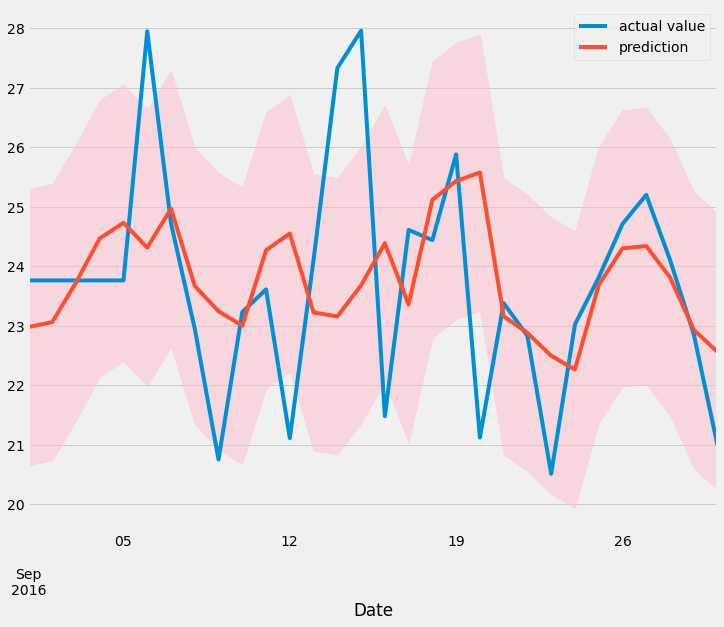

In [40]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

### Forecasting using ARMA model

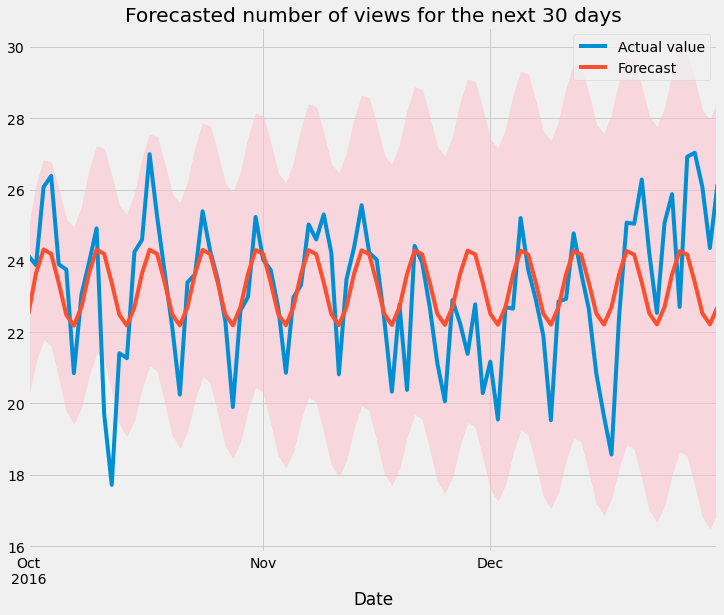

In [41]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

arma_forecast_df = pd.DataFrame({'Date':test.index,'Views':forecast_values.predicted_mean,'lower_views':conf_interval['lower Views'].values,'upper_views':conf_interval['upper Views'].values})
arma_forecast_df = arma_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arma_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax,label='Forecast')
plt.fill_between(arma_forecast_df.index, \
                arma_forecast_df.lower_views, \
                arma_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [42]:
rmse_values = []
rmse_values.append(('ARMA',np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

## ARIMA model

In [43]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(train, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
arima_aic_bic_df = arima_aic_bic_df.sort_values(by=['aic','bic'])

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84642D+00    |proj g|=  1.41549D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   1.497D-06   1.846D+00
  F =   1.8464192190920399     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.68770D+00    |proj g|=  2.97086D-03

At iterate   10    f=  1.68721D+00    |proj g|=  1.21865D-02

At iterate   15    f=  1.68691D+00    |proj g|=  1.96182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     20      1     0     0   3.383D-05   1.687D+00
  F =   1.6869062419658689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70578D+00    |proj g|=  1.22256D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  1.68097D+00    |proj g|=  7.07552D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     20      1     0     0   1.148D-05   1.681D+00
  F =   1.6809737017086002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80567D+00    |proj g|=  2.08741D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.71199D+00    |proj g|=  6.43295D-04

At iterate   45    f=  1.71183D+00    |proj g|=  4.10730D-03

At iterate   50    f=  1.71169D+00    |proj g|=  4.07357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   4.074D-04   1.712D+00
  F =   1.7116915281196858     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69848D+00    |proj g|=  9.36989D-02

At iter

 This problem is unconstrained.



At iterate   45    f=  1.60114D+00    |proj g|=  1.30011D-01

At iterate   50    f=  1.60106D+00    |proj g|=  1.72187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66      1     0     0   1.722D-03   1.601D+00
  F =   1.6010615909021173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69559D+00    |proj g|=  7.80510D-02

At iterate    5    f=  1.68831D+00    |proj g|=  3.61875D-02

At iter

 This problem is unconstrained.



At iterate   35    f=  1.60079D+00    |proj g|=  2.45223D-01

At iterate   40    f=  1.59484D+00    |proj g|=  2.93158D-01

At iterate   45    f=  1.59409D+00    |proj g|=  3.30059D-03

At iterate   50    f=  1.59408D+00    |proj g|=  5.47848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   5.478D-03   1.594D+00
  F =   1.5940840191249352     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.60948D+00    |proj g|=  1.20236D-01

At iterate   30    f=  1.60077D+00    |proj g|=  9.73150D-02

At iterate   35    f=  1.59780D+00    |proj g|=  2.25675D-01

At iterate   40    f=  1.59491D+00    |proj g|=  4.67501D-02

At iterate   45    f=  1.59328D+00    |proj g|=  7.99913D-02

At iterate   50    f=  1.59267D+00    |proj g|=  2.88815D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   2.888D-02   1.593D+00
  F =   1.5926661006200826     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70413D+00    |proj g|=  2.19204D-01

At iterate    5    f=  1.66346D+00    |proj g|=  2.24698D-02

At iterate   10    f=  1.63951D+00    |proj g|=  8.76176D-02

At iterate   15    f=  1.61745D+00    |proj g|=  4.54139D-02

At iterate   20    f=  1.61138D+00    |proj g|=  8.67240D-02

At iterate   25    f=  1.60366D+00    |proj g|=  1.80120D-01

At iterate   30    f=  1.59969D+00    |proj g|=  1.08321D-01

At iterate   35    f=  1.59458D+00    |proj g|=  2.66172D-02

At iterate   40    f=  1.59263D+00    |proj g|=  1.39272D-01

At iterate   45    f=  1.59248D+00    |proj g|=  7.74570D-03

At iterate   50    f=  1.59248D+00    |proj g|=  1.80688D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.68304D+00    |proj g|=  3.27235D-02

At iterate   10    f=  1.68166D+00    |proj g|=  3.17720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.957D-06   1.682D+00
  F =   1.6816560574621113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43233D+00    |proj g|=  1.26206D+00

At iterate    5    f=  1.71738D+00    |proj g|=  4.13848D-02

At iter

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67507D+00    |proj g|=  1.57303D-01

At iterate    5    f=  1.64759D+00    |proj g|=  8.28353D-02

At iterate   10    f=  1.62120D+00    |proj g|=  7.18653D-02

At iterate   15    f=  1.61096D+00    |proj g|=  1.11274D-01

At iterate   20    f=  1.60689D+00    |proj g|=  2.38772D-01

At iterate   25    f=  1.60350D+00    |proj g|=  3.76049D-02

At iterate   30    f=  1.60180D+00    |proj g|=  2.66699D-02

At iterate   35    f=  1.60113D+00    |proj g|=  1.85020D-01

At iterate   40    f=  1.60059D+00    |proj g|=  2.59689D-01

At iterate   45    f=  1.60039D+00    |proj g|=  1.56004D-01

At iterate   50    f=  1.60034D+00    |proj g|=  3.62222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.



At iterate   15    f=  1.60940D+00    |proj g|=  3.03323D-02

At iterate   20    f=  1.60484D+00    |proj g|=  3.37432D-02

At iterate   25    f=  1.59969D+00    |proj g|=  3.39867D-01

At iterate   30    f=  1.59659D+00    |proj g|=  3.47998D-01

At iterate   35    f=  1.59479D+00    |proj g|=  5.98968D-01

At iterate   40    f=  1.59392D+00    |proj g|=  1.52457D-01

At iterate   45    f=  1.59372D+00    |proj g|=  6.16252D-03

At iterate   50    f=  1.59371D+00    |proj g|=  2.48657D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62      1     0     0   2.487D-02   1.594D+00
  F =   1.59371436687

 This problem is unconstrained.



At iterate   20    f=  1.60501D+00    |proj g|=  5.16927D-02

At iterate   25    f=  1.59983D+00    |proj g|=  5.45273D-01

At iterate   30    f=  1.59909D+00    |proj g|=  1.09529D-01

At iterate   35    f=  1.59795D+00    |proj g|=  6.20349D-02

At iterate   40    f=  1.59471D+00    |proj g|=  2.67688D-01

At iterate   45    f=  1.59234D+00    |proj g|=  3.08854D-01

At iterate   50    f=  1.59205D+00    |proj g|=  2.40203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   2.402D-02   1.592D+00
  F =   1.5920523453041437     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.65688D+00    |proj g|=  3.99946D-02

At iterate   25    f=  1.65609D+00    |proj g|=  1.36125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     39      1     0     0   1.098D-05   1.656D+00
  F =   1.6560933530122690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67165D+00    |proj g|=  1.14442D-01

At iterate    5    f=  1.66032D+00    |proj g|=  4.73183D-03

At iter

 This problem is unconstrained.



At iterate   40    f=  1.60542D+00    |proj g|=  2.33995D-01

At iterate   45    f=  1.59926D+00    |proj g|=  1.87217D-02

At iterate   50    f=  1.59871D+00    |proj g|=  1.25853D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   1.259D-01   1.599D+00
  F =   1.5987135140079098     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67092D+00    |proj g|=  9.60430D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.60158D+00    |proj g|=  3.13404D-01

At iterate   30    f=  1.59857D+00    |proj g|=  6.14426D-01

At iterate   35    f=  1.59515D+00    |proj g|=  2.20729D-01

At iterate   40    f=  1.59393D+00    |proj g|=  2.27049D-01

At iterate   45    f=  1.59274D+00    |proj g|=  1.24583D-01

At iterate   50    f=  1.59260D+00    |proj g|=  9.36854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   9.369D-02   1.593D+00
  F =   1.5926010103265760     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.60274D+00    |proj g|=  6.85522D-02

At iterate   35    f=  1.60171D+00    |proj g|=  1.33272D-01

At iterate   40    f=  1.60071D+00    |proj g|=  4.36912D-02

At iterate   45    f=  1.60035D+00    |proj g|=  5.46810D-02

At iterate   50    f=  1.59970D+00    |proj g|=  5.57251D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   5.573D-02   1.600D+00
  F =   1.5997008543503335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.59544D+00    |proj g|=  8.01222D-02

At iterate   30    f=  1.59374D+00    |proj g|=  1.96720D-02

At iterate   35    f=  1.59178D+00    |proj g|=  2.22085D-01

At iterate   40    f=  1.58981D+00    |proj g|=  2.18897D-02

At iterate   45    f=  1.58920D+00    |proj g|=  3.74199D-02

At iterate   50    f=  1.58839D+00    |proj g|=  2.73962D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     65      1     0     0   2.740D-02   1.588D+00
  F =   1.5883915168206353     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.66405D+00    |proj g|=  2.28640D-02

At iterate   15    f=  1.65350D+00    |proj g|=  9.37806D-02

At iterate   20    f=  1.63997D+00    |proj g|=  4.12055D-02

At iterate   25    f=  1.63355D+00    |proj g|=  1.10791D-01

At iterate   30    f=  1.62892D+00    |proj g|=  5.54212D-02

At iterate   35    f=  1.62793D+00    |proj g|=  5.26302D-02

At iterate   40    f=  1.62742D+00    |proj g|=  2.25165D-02

At iterate   45    f=  1.62685D+00    |proj g|=  2.62897D-02

At iterate   50    f=  1.62653D+00    |proj g|=  1.36771D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65332D+00    |proj g|=  5.99263D-02

At iterate    5    f=  1.64705D+00    |proj g|=  3.83495D-02

At iterate   10    f=  1.63356D+00    |proj g|=  4.83724D-02

At iterate   15    f=  1.62400D+00    |proj g|=  6.11941D-02

At iterate   20    f=  1.61823D+00    |proj g|=  9.03056D-02

At iterate   25    f=  1.61193D+00    |proj g|=  4.55736D-02

At iterate   30    f=  1.60673D+00    |proj g|=  2.35250D-02

At iterate   35    f=  1.60279D+00    |proj g|=  9.72051D-02

At iterate   40    f=  1.60159D+00    |proj g|=  9.04491D-03

At iterate   45    f=  1.59828D+00    |proj g|=  2.27714D-01

At iterate   50    f=  1.59570D+00    |proj g|=  1.87633D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.



At iterate   30    f=  1.60401D+00    |proj g|=  4.40375D-02

At iterate   35    f=  1.60012D+00    |proj g|=  7.98656D-02

At iterate   40    f=  1.59893D+00    |proj g|=  3.85859D-01

At iterate   45    f=  1.59485D+00    |proj g|=  7.38801D-02

At iterate   50    f=  1.59294D+00    |proj g|=  3.10843D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   3.108D-01   1.593D+00
  F =   1.5929404275921282     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.61825D+00    |proj g|=  2.79278D-02

At iterate   10    f=  1.61252D+00    |proj g|=  2.97749D-01

At iterate   15    f=  1.60805D+00    |proj g|=  1.15341D-01

At iterate   20    f=  1.60262D+00    |proj g|=  2.03095D-02

At iterate   25    f=  1.59790D+00    |proj g|=  2.03603D-02

At iterate   30    f=  1.59716D+00    |proj g|=  2.44284D-02

At iterate   35    f=  1.59645D+00    |proj g|=  1.02082D-01

At iterate   40    f=  1.59460D+00    |proj g|=  9.22774D-02

At iterate   45    f=  1.59320D+00    |proj g|=  1.48254D-01

At iterate   50    f=  1.59183D+00    |proj g|=  3.56814D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.59849D+00    |proj g|=  3.39519D-02

At iterate   10    f=  1.59403D+00    |proj g|=  4.26698D-02

At iterate   15    f=  1.59308D+00    |proj g|=  7.54735D-02

At iterate   20    f=  1.59247D+00    |proj g|=  9.67637D-03

At iterate   25    f=  1.59214D+00    |proj g|=  2.04240D-02

At iterate   30    f=  1.59141D+00    |proj g|=  1.46081D-01

At iterate   35    f=  1.59049D+00    |proj g|=  2.18640D-01

At iterate   40    f=  1.58998D+00    |proj g|=  2.26428D-01

At iterate   45    f=  1.58959D+00    |proj g|=  7.10497D-02

At iterate   50    f=  1.58934D+00    |proj g|=  9.19928D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.65685D+00    |proj g|=  5.16927D-02

At iterate   10    f=  1.62799D+00    |proj g|=  1.90753D-02

At iterate   15    f=  1.62733D+00    |proj g|=  3.25399D-04

At iterate   20    f=  1.62732D+00    |proj g|=  4.54969D-04

At iterate   25    f=  1.62732D+00    |proj g|=  1.22687D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     25     33      1     0     0   1.227D-05   1.627D+00
  F =   1.6273239546714742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.62093D+00    |proj g|=  1.26436D-02

At iterate   20    f=  1.62065D+00    |proj g|=  1.40145D-02

At iterate   25    f=  1.62003D+00    |proj g|=  9.22980D-03

At iterate   30    f=  1.61930D+00    |proj g|=  1.01938D-02

At iterate   35    f=  1.61924D+00    |proj g|=  4.24105D-03

At iterate   40    f=  1.61923D+00    |proj g|=  1.31138D-03

At iterate   45    f=  1.61923D+00    |proj g|=  2.07569D-04

At iterate   50    f=  1.61923D+00    |proj g|=  2.59690D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   2.597D-05   1.619D+00
  F =   1.61922806697

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62573D+00    |proj g|=  2.07651D-02

At iterate    5    f=  1.62431D+00    |proj g|=  2.28720D-02

At iterate   10    f=  1.62244D+00    |proj g|=  1.36018D-02

At iterate   15    f=  1.62132D+00    |proj g|=  1.60825D-02

At iterate   20    f=  1.62039D+00    |proj g|=  9.93567D-03

At iterate   25    f=  1.61983D+00    |proj g|=  2.24745D-02

At iterate   30    f=  1.61960D+00    |proj g|=  8.31039D-03

At iterate   35    f=  1.61868D+00    |proj g|=  4.48631D-02

At iterate   40    f=  1.61455D+00    |proj g|=  2.12778D-01

At iterate   45    f=  1.61049D+00    |proj g|=  2.18261D-01

At iterate   50    f=  1.60205D+00    |proj g|=  1.14012D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.60779D+00    |proj g|=  3.06129D-02

At iterate   20    f=  1.60262D+00    |proj g|=  1.91391D-01

At iterate   25    f=  1.59938D+00    |proj g|=  6.33693D-02

At iterate   30    f=  1.59854D+00    |proj g|=  5.83203D-02

At iterate   35    f=  1.59804D+00    |proj g|=  7.04054D-02

At iterate   40    f=  1.59730D+00    |proj g|=  3.73711D-01

At iterate   45    f=  1.59693D+00    |proj g|=  3.31903D-02

At iterate   50    f=  1.59602D+00    |proj g|=  8.55584D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   8.556D-02   1.596D+00
  F =   1.59602397214

 This problem is unconstrained.



At iterate   10    f=  1.60048D+00    |proj g|=  1.87202D-02

At iterate   15    f=  1.59644D+00    |proj g|=  3.24319D-01

At iterate   20    f=  1.59481D+00    |proj g|=  3.94490D-02

At iterate   25    f=  1.59344D+00    |proj g|=  7.49747D-02

At iterate   30    f=  1.59297D+00    |proj g|=  4.14427D-02

At iterate   35    f=  1.59260D+00    |proj g|=  5.31278D-02

At iterate   40    f=  1.59239D+00    |proj g|=  7.61668D-02

At iterate   45    f=  1.59162D+00    |proj g|=  1.61350D-01

At iterate   50    f=  1.59132D+00    |proj g|=  1.27059D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     60   

### Prediction using ARIMA

In [44]:
arima_model = SARIMAX(train,order=(int(aic_bic_df.iloc[0]['p']),1,int(aic_bic_df.iloc[0]['q'])))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67507D+00    |proj g|=  1.57303D-01

At iterate    5    f=  1.64759D+00    |proj g|=  8.28353D-02

At iterate   10    f=  1.62120D+00    |proj g|=  7.18653D-02

At iterate   15    f=  1.61096D+00    |proj g|=  1.11274D-01

At iterate   20    f=  1.60689D+00    |proj g|=  2.38772D-01

At iterate   25    f=  1.60350D+00    |proj g|=  3.76049D-02

At iterate   30    f=  1.60180D+00    |proj g|=  2.66699D-02

At iterate   35    f=  1.60113D+00    |proj g|=  1.85020D-01

At iterate   40    f=  1.60059D+00    |proj g|=  2.59689D-01

At iterate   45    f=  1.60039D+00    |proj g|=  1.56004D-01

At iterate   50    f=  1.60034D+00    |proj g|=  3.62222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [45]:
with open('model/arima_model.pkl', 'wb') as f:
    pickle.dump(arima_model, f)

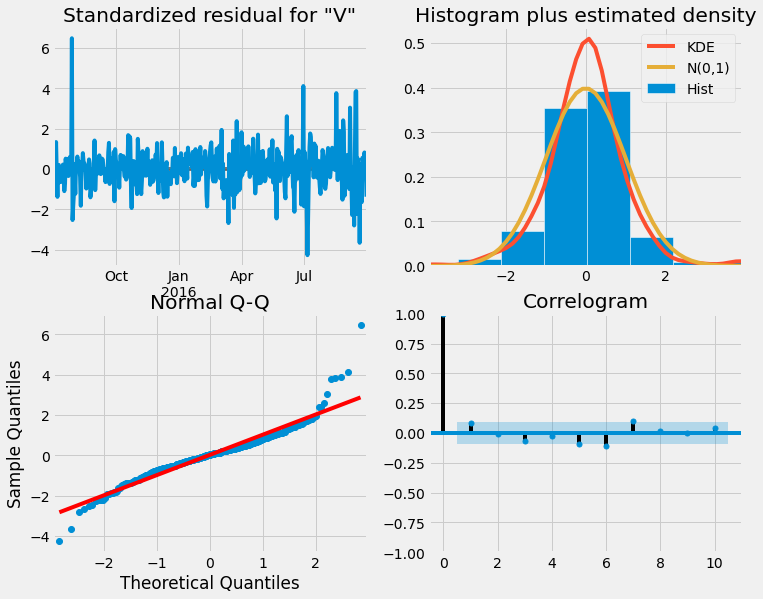

In [46]:
arima_result.plot_diagnostics()
plt.show()

In [47]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Views   No. Observations:                  458
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -732.955
Date:                Tue, 09 Aug 2022   AIC                           1481.910
Time:                        17:08:40   BIC                           1514.907
Sample:                    07-01-2015   HQIC                          1494.907
                         - 09-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2608      0.040      6.548      0.000       0.183       0.339
ar.L2          0.2290      0.051      4.530      0.000       0.130       0.328
ar.L3         -0.9855      0.040    -24.530      0.000      -1.064      -0.907
ma.L1         -0.9859      0.043    -23.172      0.000      -1.069      -0.903
ma.L2         -0.0640      0.066     -0.975      0.330      -0.193       0.065
ma.L3          1.1635      0.064     18.083      0.000       1.037       1.290
ma.L4         -0.7184      0.033    -21.450      0.000      -0.784      -0.653
sigma2         1.4255      0.052     27.321      0.000       1.323       1.528
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):               710.12
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

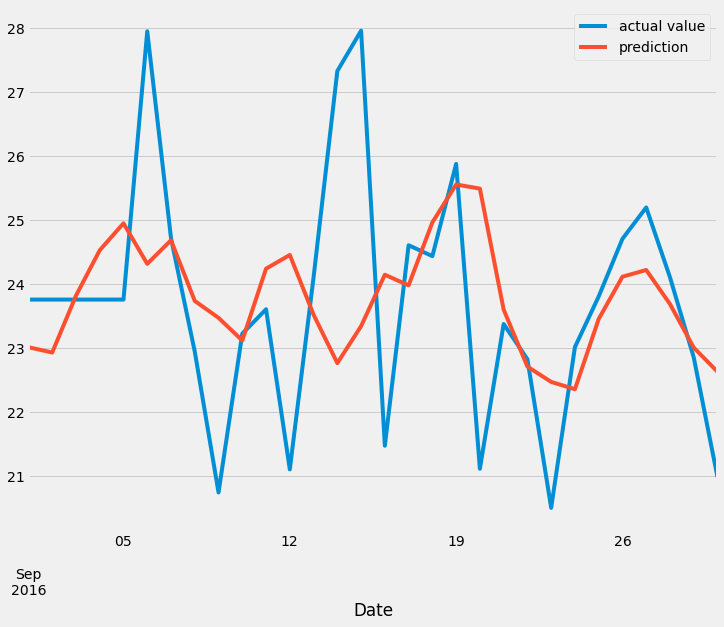

In [48]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean[-30:].plot(ax=ax,label='prediction')
plt.legend()
plt.show()

### Forecasting using ARIMA model

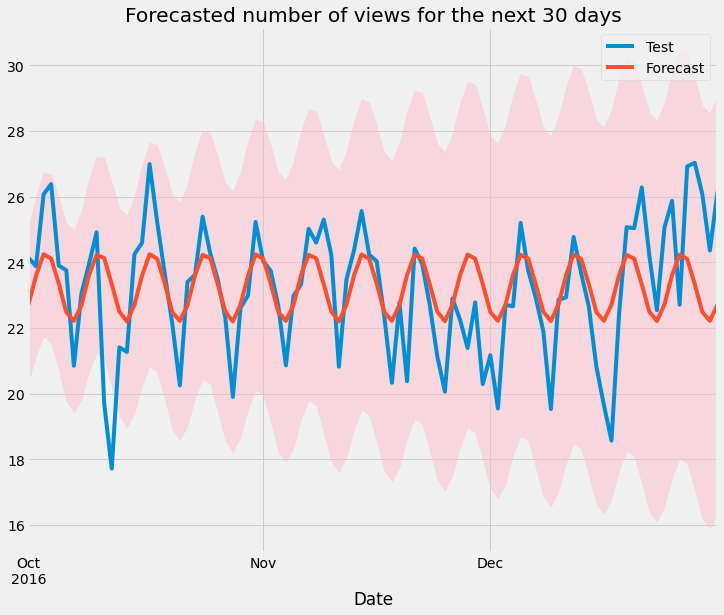

In [49]:
arima_forecast_values = arima_result.get_forecast(steps=test.shape[0])
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

arima_forecast_df = pd.DataFrame({'Date':test.index,'Views':arima_forecast_values.predicted_mean,'lower_views':arima_conf_interval['lower Views'].values,'upper_views':arima_conf_interval['upper Views'].values})
arima_forecast_df = arima_forecast_df.set_index('Date')

fig,ax=plt.subplots()
test.rename(columns={'Views':'Test'}).plot(ax=ax)
arima_forecast_df[['Views']].rename(columns={'Views':'Forecast'}).plot(ax=ax)
plt.fill_between(arima_forecast_df.index, \
                arima_forecast_df.lower_views, \
                arima_forecast_df.upper_views, \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [50]:
rmse_values.append(('ARIMA',np.sqrt(np.mean(np.square(arima_forecast_df.Views.values - test.Views.values)))))

## Exponential smoothing model

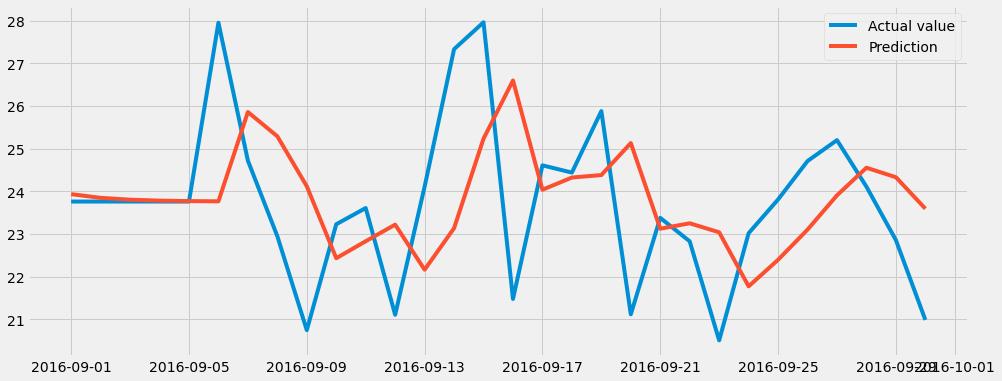

In [51]:
exp_smoothing_model = SimpleExpSmoothing(train)
exp_smoothing_result = exp_smoothing_model.fit(smoothing_level=0.5,optimized=True)

# Prediction using Exponential Smoothing model
exp_smoothing_prediction = exp_smoothing_result.predict(start=train[-30:-29].index[0],end=train[-1:].index[0])

plt.figure(figsize=(15,6))
plt.plot(train[-30:], label='Actual value')
plt.plot(exp_smoothing_prediction, label='Prediction')
plt.legend(loc='best')
plt.show()

In [52]:
with open('model/exp_smoothing_model.pkl', 'wb') as f:
    pickle.dump(exp_smoothing_model, f)

### Forecasting using Exponential Smoothing model

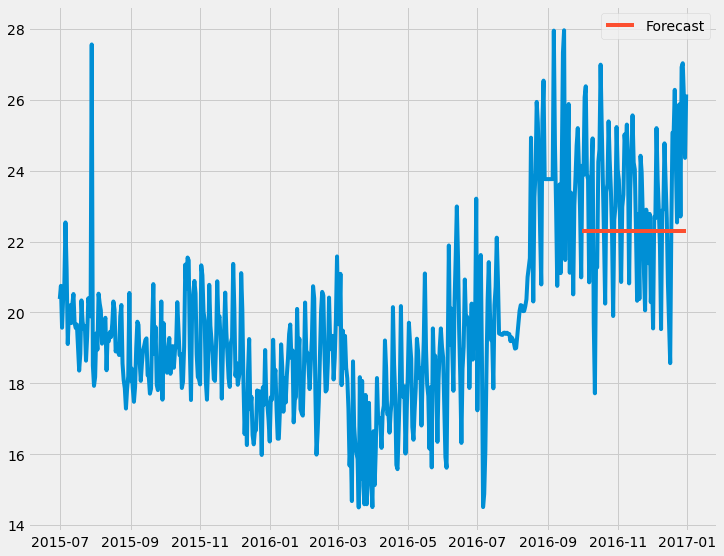

In [53]:
exp_smoothing_forecast = exp_smoothing_result.forecast(test.shape[0])

plt.plot(top_page_df)
plt.plot(exp_smoothing_forecast, label='Forecast')
plt.legend(loc='best')
plt.show()

In [54]:
rmse_values.append(('Exponential Smoothing',np.sqrt(np.mean(np.square(exp_smoothing_forecast.values - test.Views.values)))))

## Prophet

In [55]:
prophet_model = Prophet()
prophet_result = prophet_model.fit(train.reset_index().rename(columns={'Date':'ds','Views':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.01977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1151.55   0.000449365       106.388       5e-06       0.001      150  LS failed, Hessian reset 
      99       1151.63    0.00013242       92.2767      0.6134      0.6134      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       1151.67   1.98277e-05       93.6521   2.774e-07       0.001      232  LS failed, Hessian reset 
     199       1151.67   8.52391e-06       80.5936           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       1151.71   2.22534e-05       76.1918   3.286e-07       0.001      392  LS failed, Hessian reset 
     249       1151.71   9.05761e-09       73.3503     0.04253     0.04253      427   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

In [56]:
with open('model/prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

### Prediction using Prophet

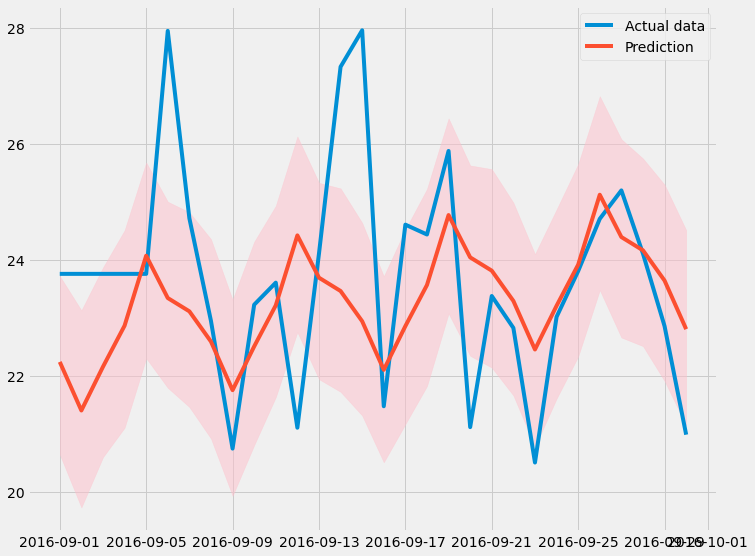

In [57]:
future = prophet_model.make_future_dataframe(periods=0)
prophet_prediction = prophet_model.predict(future)

prediction = prophet_prediction[['ds','yhat_lower','yhat_upper','yhat']][-30:]
plt.plot(train[-30:], label='Actual data')
plt.plot(prediction['ds'],prediction['yhat'],label='Prediction')
plt.fill_between(prediction['ds'],prediction['yhat_lower'],prediction['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.show()

### Forecasting using Prophet

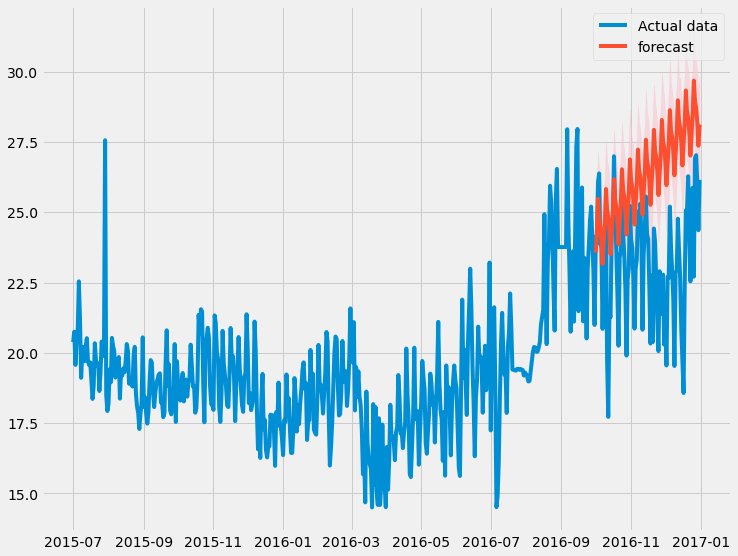

In [58]:
future = prophet_model.make_future_dataframe(periods=test.shape[0])
prophet_forecast = prophet_model.predict(future)

forecast = prophet_forecast[['ds','yhat_lower','yhat_upper','yhat']][-test.shape[0]:]
plt.plot(top_page_df, label='Actual data')
plt.plot(forecast['ds'],forecast['yhat'],label='forecast')
plt.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'],color='pink',alpha=0.5)
plt.legend(loc='best')
plt.show()

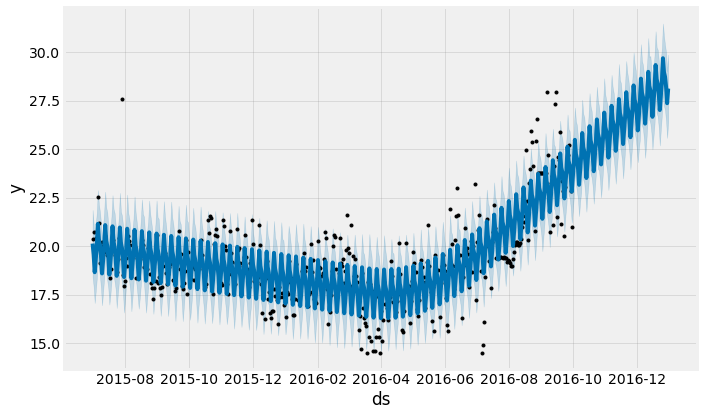

In [59]:
fig = prophet_model.plot(prophet_forecast)

In [60]:
rmse_values.append(('Prophet',np.sqrt(np.mean(np.square(forecast.yhat.values - test.Views.values)))))

## Auto-Arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1695.320, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1668.147, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1623.448, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1693.320, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1576.416, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1574.532, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1661.986, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1552.154, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1634.091, Time=0.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1541.734, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1599.304, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1532.731, Time=0.08 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1562.410, Time=0.05 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : 

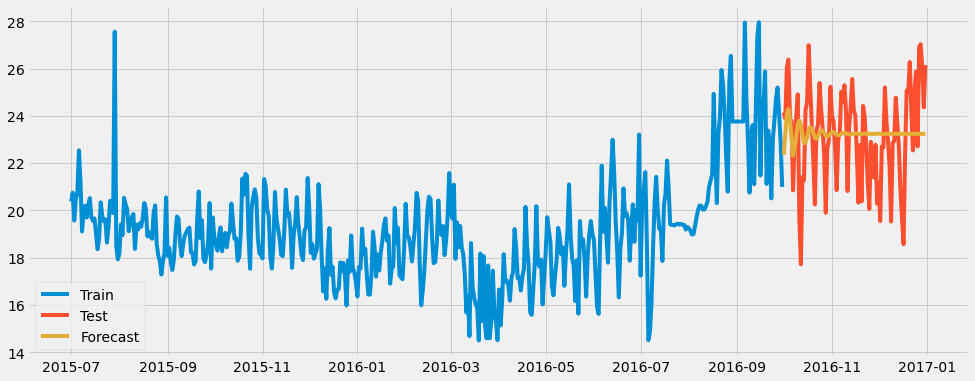

In [61]:
auto_arima_model = auto_arima(train,start_p=2,max_p=7,start_q=2,max_q=7, m=1,stationary=False,trace=True, seasonal=False,error_action='ignore',suppress_warnings=True)
auto_arima_model.fit(train)

auto_arima_forecast = auto_arima_model.predict(n_periods=test.shape[0])
auto_arima_forecast = pd.DataFrame(auto_arima_forecast,index = test.index,columns=['Forecast'])

plt.figure(figsize=(15,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(auto_arima_forecast, label='Forecast')
plt.legend()
plt.show()

In [62]:
with open('model/auto_arima_model.pkl', 'wb') as f:
    pickle.dump(auto_arima_model, f)

In [63]:
rmse_values.append(('Auto-arima',np.sqrt(np.mean(np.square(auto_arima_forecast.values - test.Views.values)))))

### Root Mean Squared Error

In [64]:
rmse_df = pd.DataFrame(rmse_values,columns=['Model','RMSE_values']).sort_values('RMSE_values')
rmse_df

,Model,RMSE_values
0,ARMA,1.725461
1,ARIMA,1.729838
4,Auto-arima,2.014473
2,Exponential Smoothing,2.189830
3,Prophet,3.802035
